In [1]:
from utils import make_need_tree,visualize_tree,make_storage,make_requirement_tree,make_task_list

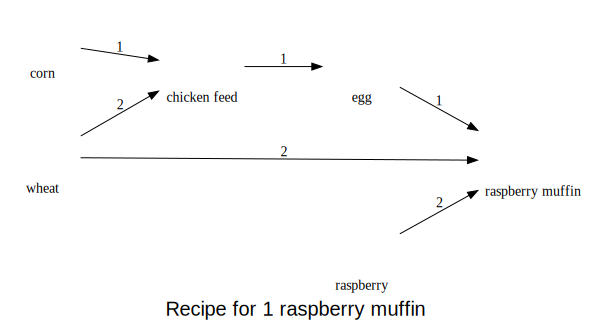

In [2]:
tree = make_need_tree('Raspberry muffin',1)
visualize_tree(tree)

In [3]:
storage = make_storage(100)
req_tree=make_requirement_tree('raspberry muffin',storage)
req_tree

{'name': 'raspberry muffin',
 'quantity': 1,
 'children': [{'name': 'egg',
   'quantity': 1,
   'children': [{'name': 'chicken feed',
     'quantity': 1,
     'children': [{'name': 'corn', 'quantity': 1, 'children': []},
      {'name': 'wheat', 'quantity': 2, 'children': []}]}]},
  {'name': 'raspberry', 'quantity': 2, 'children': []},
  {'name': 'wheat', 'quantity': 2, 'children': []}]}

In [4]:
tasks=make_task_list(req_tree)
tasks[:2]

[{'id': 1,
  'name': 'raspberry muffin',
  'dependencies': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'duration': 2700,
  'source': 'Bakery',
  'machine_id': None},
 {'id': 2,
  'name': 'egg',
  'dependencies': [3, 4, 5, 6],
  'duration': 1200,
  'source': 'Chicken',
  'machine_id': None}]

In [5]:
# number of machines
sources={
    'Bakery':1, 'Chicken':1, 'Feed Mill':1, 'Field':2, 'Raspberry bush':1
}
machines ={}
# make machines is: key is same as sources, value is a list of machine_id
# machine_id must be unique from other machines
count  = 0
for key,value in sources.items():
    machines[key]=list(range(count,count+value))
    count+=value
machines

{'Bakery': [0],
 'Chicken': [1],
 'Feed Mill': [2],
 'Field': [3, 4],
 'Raspberry bush': [5]}

In [6]:
# function to check if task b depends on task a
def check_dependency(task_a_pos,task_b_pos):
    """check if task b is in the dependencies of task a
    task_a_pos: position of task a in tasks list
    task_b_pos: position of task b in tasks list
    
    return: True if task b depends on task a, False otherwise
    """
    task_a = tasks[task_a_pos]
    task_b = tasks[task_b_pos]
    return task_b['id'] in task_a['dependencies']

In [9]:
import random

def make_chromosome(tasks,machines):
    """make a chromosome from tasks and machines
    tasks: list of task
    machines: dictionary of machines
    
    return: a chromosome (list of tuple (id,machine_id))
    id is the position of the task in the task list
    machine_id is the id of the machine
    the order of the tuple is the order of the task
    """
    chromosome=[]
    for i in range(len(tasks)):
        task=tasks[i]
        machine_id=random.choice(machines[task['source']])
        chromosome.append((i,machine_id))
    # # random shuffle the chromosome
    for i in range(len(chromosome)):
        for j in range(i+1,len(chromosome)):
            if not check_dependency(chromosome[i][0],chromosome[j][0]):
                if random.random()<0.5:
                    chromosome[i],chromosome[j]=chromosome[j],chromosome[i]
    return chromosome

def chromosome_to_task_list(chromosome):
    """convert a chromosome to a task list
    chromosome: a chromosome
    
    return: a task list
    """
    task_list=[]
    for task_id,machine_id in chromosome:
        temp_task = tasks[task_id].copy()
        temp_task['machine_id']=machine_id
        task_list.append(temp_task)
    return task_list
    

chromosome = make_chromosome(tasks,machines)
chromosome_to_task_list(chromosome)

[{'id': 1,
  'name': 'raspberry muffin',
  'dependencies': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'duration': 2700,
  'source': 'Bakery',
  'machine_id': 0},
 {'id': 10,
  'name': 'wheat',
  'dependencies': [],
  'duration': 120,
  'source': 'Field',
  'machine_id': 3},
 {'id': 9,
  'name': 'wheat',
  'dependencies': [],
  'duration': 120,
  'source': 'Field',
  'machine_id': 3},
 {'id': 8,
  'name': 'raspberry',
  'dependencies': [],
  'duration': 64800,
  'source': 'Raspberry bush',
  'machine_id': 5},
 {'id': 2,
  'name': 'egg',
  'dependencies': [3, 4, 5, 6],
  'duration': 1200,
  'source': 'Chicken',
  'machine_id': 1},
 {'id': 6,
  'name': 'wheat',
  'dependencies': [],
  'duration': 120,
  'source': 'Field',
  'machine_id': 4},
 {'id': 4,
  'name': 'corn',
  'dependencies': [],
  'duration': 300,
  'source': 'Field',
  'machine_id': 3},
 {'id': 3,
  'name': 'chicken feed',
  'dependencies': [4, 5, 6],
  'duration': 300,
  'source': 'Feed Mill',
  'machine_id': 2},
 {'id': 7,
  'name': 